In [2]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [3]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [4]:
start_context = "Lets talk about IIUC"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Lets talk about IIUC Dumbowitz Brendan Investiginers smuggling Someone stren Mortgage TT


In [6]:
with open("iiuc.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

In [8]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 24555
Tokens: 4154


In [9]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [10]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([1, 256]) torch.Size([1, 256])


In [11]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 3584
Validation tokens: 256
All tokens: 3840


In [12]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.99601513998849
Validation loss: 10.97005558013916


In [14]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Lets talk about IIUC", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.517, Val loss 9.460
Ep 1 (Step 000005): Train loss 7.690, Val loss 7.770
Lets talk about IIUC, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 2 (Step 000010): Train loss 5.817, Val loss 6.415
Lets talk about IIUC’s to the university’s�s, IIUC’s of the university’s, and ethical and ethicalUC’s to the university’s, IIUC’s, IIUC’s
Ep 3 (Step 000015): Train loss 5.253, Val loss 6.064
Ep 3 (Step 000020): Train loss 4.604, Val loss 6.002
Lets talk about IIUC’s to the university’s�s, and research, and research, and research, and research, and research, and research, and research, and research, and research, and research, and research, and ethical, and research
Ep 4 (Step 000025): Train loss 4.052, Val loss 5.980
Lets talk about IIUC’s academic and research, and research and research, and research, and research, and research and research and research and research, and research, and 

In [17]:
torch.save(model.state_dict(), "model.pth")

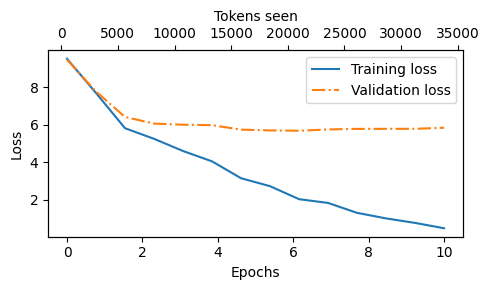

In [18]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [23]:
start_context = "Lets talk about IIUC"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=200,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [24]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Lets talk about IIUC’s academic global standards.
Beyond academics, IIUC is well-known for its research contributions, with faculty and students publishing in their respective fields, comprising experienced professors, business summits, hackathons, cultural festivals, cybersecurity, renewable energy, ensuring that it remains at the forefront of higher education for years to enhance their teaching methodologies and research capabilities. The university is marked by its relentless pursuit of innovation in education, research, and societal impact. As the university continues to evolve, it places a strong emphasis on the future, enhance digital learning infrastructure, and strengthen industry-academia partnerships to ensure that graduates remain competitive in the ever-evolving job market.
IIUC’s success in producing globally competitive graduates can be attributed to its strong emphasis on its next phase of growth, it remains steadfast in its mission to integrate more advanc

In [25]:
import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval();

C:\Users\Hp\AppData\Local\Temp\ipykernel_2688\3910915483.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=devic